<a href="https://colab.research.google.com/github/42bismuth/Alzheimer-Detection/blob/main/nlp/data_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
path = r"/content/drive/MyDrive/alzhiemers.csv"
df = pd.read_csv(path, sep="\t", encoding = 'latin1')

Data Reading and cleaning

In [19]:
df[['AD', 'Transcripts']] = df['AD,Transcripts'].str.split("," , n =1, expand=True)

df['Transcripts'] = df['Transcripts'].str.strip()
del df['AD,Transcripts']

In [5]:
# 2 sentences per row
def create_sentence_pairs(row):
    sentences = row['Transcripts'].split('.')
    pairs = [sentences[i] + sentences[i+1] for i in range(0, len(sentences)-1, 2)]
    labels = [row['AD']] * len(pairs)
    return pd.DataFrame({'Transcripts': pairs, 'AD': labels})

new_df = pd.concat(df.apply(create_sentence_pairs, axis=1).tolist(), ignore_index=True)
new_df['AD'] = new_df['AD'].astype('int')

df = new_df

Class 0 samples:  1421
Class 1 samples:  1404


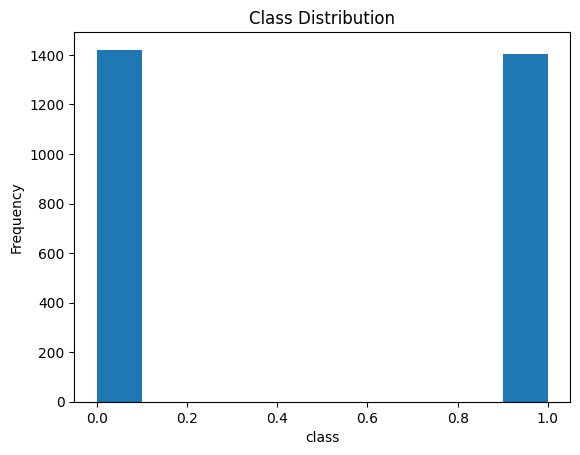

In [12]:
counts, bins = np.histogram(df['AD'])
plt.hist(bins[:-1], bins, weights=counts)
plt.title("Class Distribution")
plt.xlabel('class')
plt.ylabel('Frequency')
print("Class 0 samples: ",len(df[df['AD']==0]))
print("Class 1 samples: ",len(df[df['AD']==1]))
plt.show()

In [20]:
# 1 sentence per row + delete rows with less than 3 words
split_transcripts = df['Transcripts'].str.split('.')
print(split_transcripts)

repeated_labels = [label for label, sentences_list in zip(df['AD'], split_transcripts) for _ in sentences_list]
print(len(repeated_labels))

sentences = [sentence.strip() for sentences_list in split_transcripts for sentence in sentences_list]
print(len(sentences))

if len(repeated_labels) != len(sentences):
    raise ValueError("Lengths of arrays must match")


new_df = pd.DataFrame({
    'Transcripts': sentences,
    'AD': repeated_labels
})


new_df.reset_index(drop=True, inplace=True)
new_df['AD'] = new_df['AD'].astype('int')
#delete rows
word_counts = new_df['Transcripts'].str.split().str.len()

new_df = new_df[word_counts > 4]

new_df.reset_index(drop=True, inplace=True)
df = new_df

0      [the scene is in the in the kitchen ,  the mot...
1      [" oh I see the sink is running over ,  I see ...
2      [a boy and a girl are in the kitchen with thei...
3      [it was summertime and mother and the children...
4      [wait until I put my glasses on ,  oh ? there'...
                             ...                        
493    [well this one is in the cookie jar ,  and thi...
494    [the little boy is on the stool which is tippi...
495    [oh you want me to tell you ,  the mother and ...
496    [oh that kid's gonna get a good spill off of t...
497    [ah oh boy ,   oh the kids are trying to get t...
Name: Transcripts, Length: 498, dtype: object
5902
5902


Class 0 samples:  2219
Class 1 samples:  2148


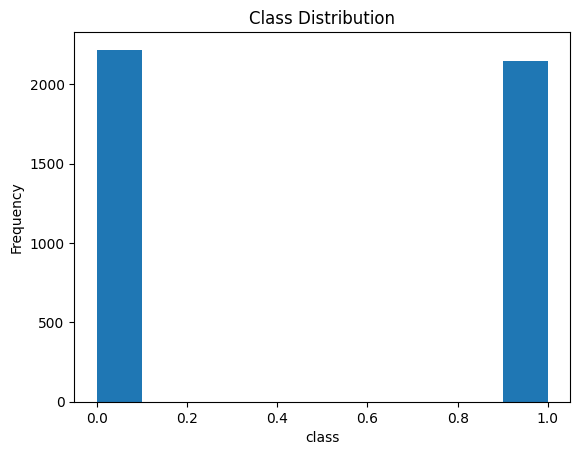

In [7]:
counts, bins = np.histogram(df['AD'])
plt.hist(bins[:-1], bins, weights=counts)
plt.title("Class Distribution")
plt.xlabel('class')
plt.ylabel('Frequency')
print("Class 0 samples: ",len(df[df['AD']==0]))
print("Class 1 samples: ",len(df[df['AD']==1]))
plt.show()

Data Preprocessing

In [21]:
import string

table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
string_punctuation_1 = string.punctuation.replace(".","").replace("`","").replace("'","")
table_ = str.maketrans(string_punctuation_1, ' '*len(string_punctuation_1))
printable = set(string.printable)


def clean_data(text):


    sentence = text.lower()
    sentence_no_punct = sentence.translate(table_)
    space_remove = re.sub('\s+',' ', sentence_no_punct)
    return space_remove

df['Transcripts_cleaned'] = df['Transcripts'].apply(lambda row: clean_data(row))

In [15]:
df['Transcripts_cleaned']

0       the scene is in the in the kitchen the mother ...
1        a child is trying to get a boy is trying to g...
2           it seems to be summer out the window is open 
3        the curtains are blowing it must be a gentle ...
4        there's grass outside in the garden mother's ...
                              ...                        
2820     the little girl's reaching up there to get so...
2821    ah oh boy oh the kids are trying to get the co...
2822     and she's laughing but holding her hand up to...
2823     and their mother's doing the dishes and not d...
2824     that's all i can and tup two cups and a plate...
Name: Transcripts_cleaned, Length: 2825, dtype: object

In [22]:
stemmer = SnowballStemmer('english')
def stem_words(text):
    text = text.split()
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    return text

df['Transcripts_stem'] = df['Transcripts_cleaned'].apply(lambda row: stem_words(row))

In [20]:
df['Transcripts_stem']

0       the scene is in the in the kitchen the mother ...
1       a child is tri to get a boy is tri to get cook...
2             it seem to be summer out the window is open
3           the curtain are blow it must be a gentl breez
4       there grass outsid in the garden mother finish...
                              ...                        
2820    the littl girl reach up there to get someth fr...
2821        ah oh boy oh the kid are tri to get the cooki
2822    and she laugh but hold her hand up to him and ...
2823    and their mother do the dish and not do not be...
2824       that all i can and tup two cup and a plate end
Name: Transcripts_stem, Length: 2825, dtype: object

In [9]:
from google.colab import auth
from google.auth import default
import gspread

In [10]:
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

In [14]:
worksheet = gc.open("alzheimer's_2")
sheet1 = worksheet.sheet1

In [16]:
sheet1.update([df.columns.values.tolist()] + df.fillna(-1).values.tolist())

{'spreadsheetId': '1dqz3VB---y3kYB5BzQdkBMtgMrP0yDyBF2-YVi6fv6I',
 'updatedRange': 'Sheet1!A1:D2826',
 'updatedRows': 2826,
 'updatedColumns': 4,
 'updatedCells': 11304}

In [24]:
worksheet = gc.open("alzheimer's_1")
sheet2 = worksheet.sheet1

In [25]:
sheet2.update([df.columns.values.tolist()] + df.fillna(-1).values.tolist())

{'spreadsheetId': '1fOUQ5zcgVetupwNVSLQYLjRAynU39Qpg1y8SoNSUiuE',
 'updatedRange': 'Sheet1!A1:D4368',
 'updatedRows': 4368,
 'updatedColumns': 4,
 'updatedCells': 17472}